<a href="https://colab.research.google.com/github/bahbah94/Algo-Data/blob/master/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 88 kB 2.8 MB/s 
     |████████████████████████████████| 376 kB 38.9 MB/s 
     |████████████████████████████████| 58 kB 2.3 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=384134dc7d3369edfc5e3708fbf3aa55177cf620198e7f194253fcdb62987dfa
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=c37883f15c4f9f3b196eac9a3ee68eb940c1c4a4ce23c9a3f6cd577f531f9791
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-z7nsr9um
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-z7nsr9um
   

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 22.76 MiB/s, done.
Resolving deltas: 100% (3/3), done.


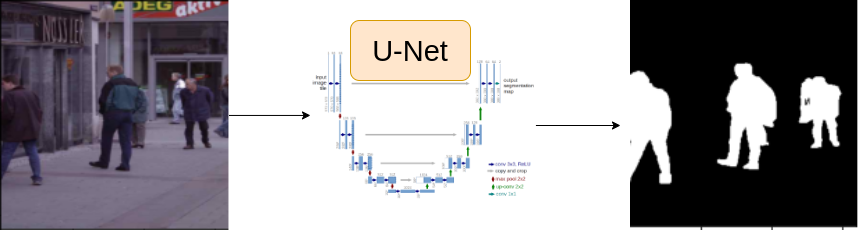

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[4]
image_path = row.images 
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) / 255.0


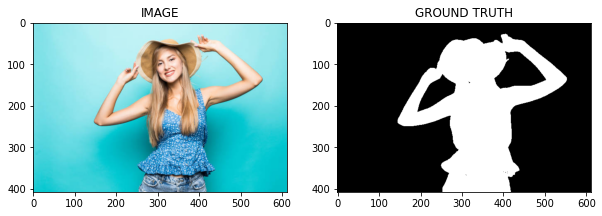

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df,test_size=0.2,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
         A.Resize(IMAGE_SIZE, IMAGE_SIZE),
         A.HorizontalFlip(p = 0.5),           
         A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
         A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ])

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self,df,augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) #(h,w,c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations :
      data = self.augmentations(image = image, mask=mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image,mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


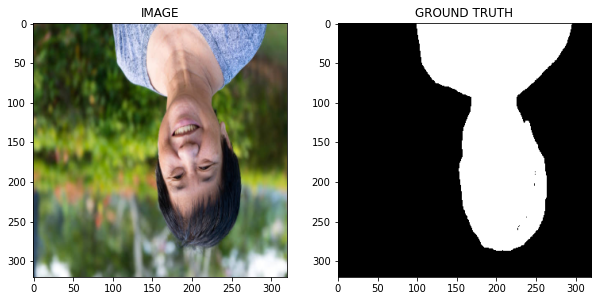

In [ ]:
idx = 3

image,mask = trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset,batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset,batch_size =BATCH_SIZE)

In [ ]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [ ]:
for image, mask in trainloader:
  break

print(f"One batch image shape :{image.shape}")
print(f"One batch mask shape :{mask.shape}")

One batch image shape :torch.Size([16, 3, 320, 320])
One batch mask shape :torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
from torch.nn.modules.conv import LazyConvTranspose2d
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self,images,masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2  = nn.BCEWithLogitsLoss()(logits,masks)
      return logits, loss1 + loss2 
    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(data_loader,model,optimizer):

  model.train()
  total_loss = 0.0

  for images,masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)

In [ ]:
def eval_fn(data_loader,model):

  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images,masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      #optimizer.zero_grad()
      logits, loss = model(images,masks)
      #loss.backward()
      #optimizer.step()

      total_loss += loss.item()

  return total_loss/len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = LR)

In [ ]:
best_valid_loss = np.inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader,model,optimizer)
  valid_loss = eval_fn(validloader,model)

  if valid_loss < best_valid_loss :
    torch.save(model.state_dict(), 'best_model_seg.pt')
    print("Saved Model")
    best_valid_loss = valid_loss

  print(f"Epoch :{i+1} train loss is {train_loss}. Valid loss {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.43it/s]


Saved Model
Epoch :1 train loss is 0.381888214747111. Valid loss 0.3852470740675926


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


Saved Model
Epoch :2 train loss is 0.30267236232757566. Valid loss 0.31314028799533844


100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


Saved Model
Epoch :3 train loss is 0.2694886257251104. Valid loss 0.22959259152412415


100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


Epoch :4 train loss is 0.22833267350991568. Valid loss 0.25074800848960876


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


Epoch :5 train loss is 0.25233881870905556. Valid loss 0.30626581609249115


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


Epoch :6 train loss is 0.2794490784406662. Valid loss 0.30934421718120575


100%|██████████| 4/4 [00:00<00:00,  4.51it/s]


Saved Model
Epoch :7 train loss is 0.2523447463909785. Valid loss 0.22067482769489288


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


Saved Model
Epoch :8 train loss is 0.22096837759017945. Valid loss 0.20032794028520584


100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


Saved Model
Epoch :9 train loss is 0.16478939553101857. Valid loss 0.19272931665182114


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


Epoch :10 train loss is 0.19363589783509572. Valid loss 0.2628665007650852


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


Epoch :11 train loss is 0.17337244947751362. Valid loss 0.20803967863321304


100%|██████████| 4/4 [00:00<00:00,  4.46it/s]


Epoch :12 train loss is 0.20720920264720916. Valid loss 0.33573028072714806


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


Epoch :13 train loss is 0.18920024534066518. Valid loss 0.24455063790082932


100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


Saved Model
Epoch :14 train loss is 0.14766910125811894. Valid loss 0.16015522554516792


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


Epoch :15 train loss is 0.14007355670134228. Valid loss 0.16274512000381947


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


Epoch :16 train loss is 0.13711889386177062. Valid loss 0.16698839887976646


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


Epoch :17 train loss is 0.17589289645353953. Valid loss 0.27285077795386314


100%|██████████| 4/4 [00:00<00:00,  4.46it/s]


Epoch :18 train loss is 0.1636418138941129. Valid loss 0.18438035249710083


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


Epoch :19 train loss is 0.13486756285031637. Valid loss 0.18154677748680115


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


Epoch :20 train loss is 0.11079567869504293. Valid loss 0.1678884383291006


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


Epoch :21 train loss is 0.10114261955022812. Valid loss 0.1804961897432804


100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Epoch :22 train loss is 0.09681825737158457. Valid loss 0.24581744894385338


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


Epoch :23 train loss is 0.10149780064821243. Valid loss 0.21895230561494827


100%|██████████| 4/4 [00:00<00:00,  4.43it/s]


Epoch :24 train loss is 0.08274127791325252. Valid loss 0.21247440576553345


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

Epoch :25 train loss is 0.09216643919547399. Valid loss 0.17044690251350403


# Task 9 : Inference

In [ ]:
idx = 20

model.load_state_dict(torch.load('/content/best_model_seg.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C,H,W) -> (1,C,H,W)

pred_mask = torch.sigmoid(logits_mask)

pred_mask = (pred_mask > 0.5)*1.0

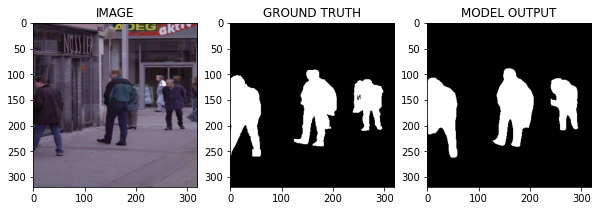

In [ ]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))